TV-Regularized Cone Beam CT for Symmetric Objects
=================================================

This example demonstrates a total variation (TV) regularized
reconstruction for cone beam CT of a cylindrically symmetric object,
by solving the problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_1 \;,$$

where $C$ is a single-view X-ray transform (with an implementation based
on a projector from the AXITOM package <cite data-cite="olufsen-2019-axitom"/>),
$\mathbf{y}$ is the measured data, $D$ is a 2D finite difference
operator, and $\mathbf{x}$ is the solution.

In [1]:
import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.xray.symcone import SymConeXRayTransform
from scico.optimize import ProximalADMM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
x_gt = create_circular_phantom((N, N), [0.4 * N, 0.2 * N, 0.1 * N], [1, 0, 0.5])

Set up the forward operator and create a test measurement.

In [3]:
C = SymConeXRayTransform(x_gt.shape, 5e2 * N, 6e2 * N, num_slabs=4)
y = C @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape).astype(np.float32)

Compute FDK reconstruction.

In [4]:
x_inv = C.fdk(y)

Set up problem and solver. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - C \mathbf{x}
  \|_2^2 + \lambda \| D \mathbf{x} \|_1 \;,$$

where $C$ is the X-ray transform and $D$ is a finite difference
operator. We use anisotropic TV, which gives slightly better performance
than isotropic TV in this case. This problem can be expressed as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; (1/2) \| \mathbf{y} -
  \mathbf{z}_0 \|_2^2 + \lambda \| \mathbf{z}_1 \|_1 \;\;
  \text{such that} \;\; \mathbf{z}_0 = C \mathbf{x} \;\; \text{and} \;\;
  \mathbf{z}_1 = D \mathbf{x} \;,$$

which can be written in the form of a standard ADMM problem

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}} \; f(\mathbf{x}) + g(\mathbf{z})
  \;\; \text{such that} \;\; A \mathbf{x} + B \mathbf{z} = \mathbf{c}$$

with

  $$f = 0 \qquad g = g_0 + g_1$$
  $$g_0(\mathbf{z}_0) = (1/2) \| \mathbf{y} - \mathbf{z}_0 \|_2^2 \qquad
  g_1(\mathbf{z}_1) = \lambda \| \mathbf{z}_1 \|_1$$
  $$A = \left( \begin{array}{c} C \\ D \end{array} \right) \qquad
  B = \left( \begin{array}{cc} -I & 0 \\ 0 & -I \end{array} \right) \qquad
  \mathbf{c} = \left( \begin{array}{c} 0 \\ 0 \end{array} \right) \;.$$

In [5]:
𝛼 = 7e1  # improve problem conditioning by balancing C and D components of A
λ = 8e0 / 𝛼  # ℓ1 norm regularization parameter
ρ = 1e-2  # ADMM penalty parameter
maxiter = 250  # number of ADMM iterations

f = functional.ZeroFunctional()
g0 = loss.SquaredL2Loss(y=y)
g1 = λ * functional.L1Norm()
g = functional.SeparableFunctional((g0, g1))
D = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

A = linop.VerticalStack((C, 𝛼 * D))
mu, nu = ProximalADMM.estimate_parameters(A)

solver = ProximalADMM(
    f=f,
    g=g,
    A=A,
    B=None,
    rho=ρ,
    mu=mu,
    nu=nu,
    x0=snp.clip(x_inv, 0.0, 1.0),
    maxiter=maxiter,
    itstat_options={"display": True, "period": 20},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x_tv = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  5.21e-01  9.618e+03  1.520e+03  1.913e+04


  20  9.91e-01  1.243e+04  2.482e+02  4.697e+01
  40  1.18e+00  1.477e+04  1.871e+02  3.444e+01


  60  1.36e+00  1.736e+04  1.565e+02  2.186e+01


  80  1.55e+00  2.081e+04  1.252e+02  1.456e+01


 100  1.74e+00  2.374e+04  1.031e+02  9.530e+00


 120  1.93e+00  2.670e+04  8.913e+01  6.640e+00


 140  2.12e+00  2.920e+04  6.763e+01  7.010e+00


 160  2.31e+00  3.156e+04  5.677e+01  5.937e+00


 180  2.50e+00  3.339e+04  4.933e+01  4.761e+00


 200  2.69e+00  3.497e+04  3.679e+01  4.327e+00


 220  2.88e+00  3.625e+04  3.294e+01  3.648e+00


 240  3.07e+00  3.734e+04  2.914e+01  2.972e+00
 249  3.16e+00  3.781e+04  2.509e+01  2.891e+00


Show results.

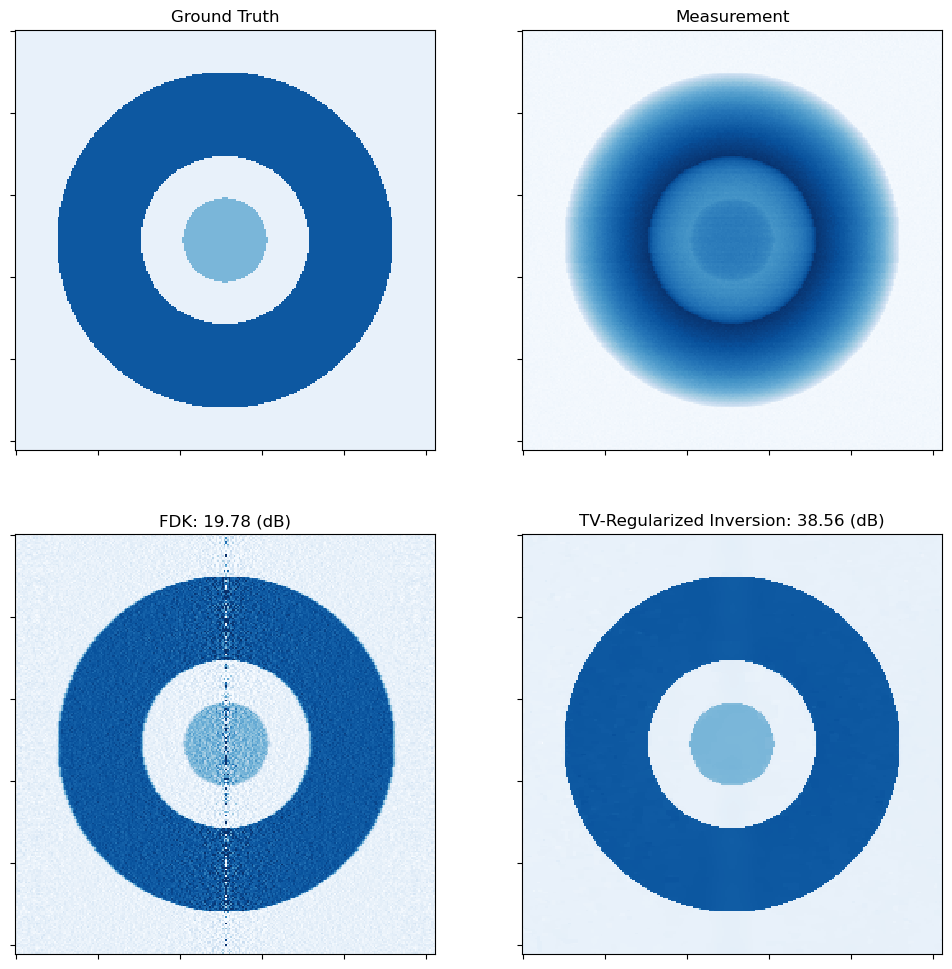

In [7]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurement", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(
    x_inv,
    title="FDK: %.2f (dB)" % metric.psnr(x_gt, x_inv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    x_tv,
    title="TV-Regularized Inversion: %.2f (dB)" % metric.psnr(x_gt, x_tv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()

Plot convergence statistics.

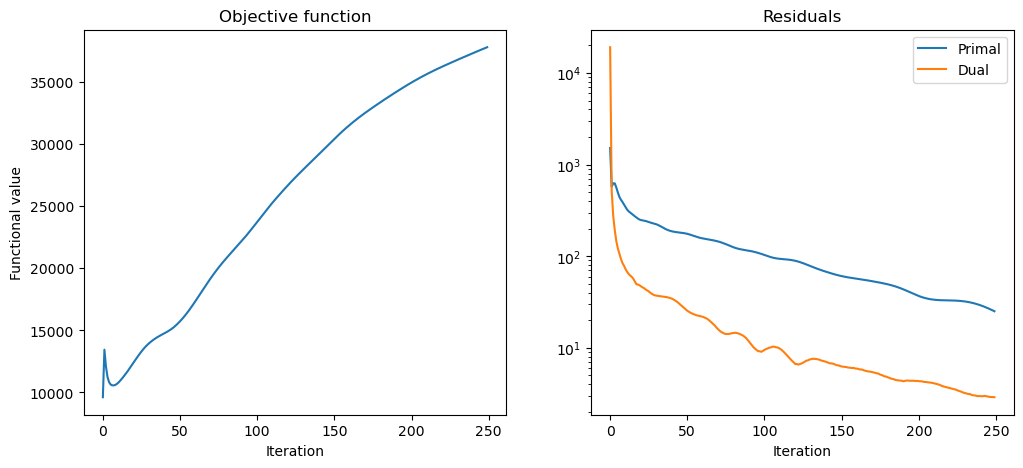

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()